# **Airlines Customer Satisfaction**

# **1. 데이터 선정 이유 및 문제 정의:**

데이터 선정 이유:
- 비즈니스에서는 고객이 서비스/제품에 얼만큼 만족하였는지가 중요하다. 실제 이용 고객의 만족도가 높아야 retention rate이 오르게 되고, 결과적으로 다음 sales로 직결이 되며 브랜드 이미지를 유지할 수 있기 때문이다.

- 그래서 이번 항공사 만족도 조사 데이터셋을 이용해서 실제로 어떤 요인이 고객의 만족도를 결정하는데 영향을 주는지를 분석하여, 그것을 토대로 개선점을 찾고 서비스 개편에 도움을 주고자 한다.

문제 정의:
- 만족했을 경우를 1, 만족하지 못하였을 경우를 0으로 지정하여서 설문조사 항목에서 어떤 서비스를 이용하였을 때에 혹은 어떤 포인트에서 고객이 점수를 높게 주었을 경우 만족한다고 응답하였는지, 어떤 포인트 때문에 만족하지 못하였는지를 분석해보고자 한다.

- 집중적으로 분석해볼 항목은, 항공사 내에서 개선할 수 있는 포인트에서의 만족/불만족이다. 정해져있는 상황과 같은 비즈니스 클래스를 이용하였는지, 출장이였는지의 포인트보다는 항공사에서 개선해나갈 수 있는 고객서비스나 기내서비스와 같은 항목을 확인해보는 것이 중요하다. 

- 이번 프로젝트 이후에서는, 조금 더 자세하게 좌석클래스 별로 나누어서 기내식 서비스나 고객서비스, 좌석 서비스를 비교해보아야할 것 같다. 아무래도 좌석클래스에 따라 항공사 서비스가 많이 달라지기 때문에 어떤 서비스를 받았는지에 따라 만족하는지 불만족하는지가 실제로 차이가 날 것이기 때문이다.








---


# **2. 데이터 준비**

## **Part 1: Import Dataset + Libraries**

In [ ]:
# 필요한 라이브러리들 먼저 호출하고 시작

%%capture
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pandas-profiling==2.*
    !pip install pdpbox
    !pip install shap
    !pip install catboost

import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.set(style="whitegrid")
pd.options.display.float_format = '{:,.2f}'.format

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, recall_score, classification_report, mean_absolute_error
import shap
import eli5
from eli5.sklearn import PermutationImportance
from pdpbox.pdp import pdp_isolate, pdp_plot

In [ ]:
!pip install kaggle --quiet kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"chloe18","key":"f8ed6df18b3aefeea062fca5b2ce9876"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d sjleshrac/airlines-customer-satisfaction

  0% 0.00/1.64M [00:00<?, ?B/s]
100% 1.64M/1.64M [00:00<00:00, 115MB/s]


In [ ]:
!unzip airlines-customer-satisfaction.zip -d .

Archive:  airlines-customer-satisfaction.zip
  inflating: ./Invistico_Airline.csv  


In [ ]:
# 데이터셋 저장

df = pd.read_csv('/content/Invistico_Airline.csv')

In [ ]:
print(df.shape)
df.head(3)

(129880, 23)


,satisfaction,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,Gate location,Inflight wifi service,Inflight entertainment,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes
0,satisfied,Female,Loyal Customer,65,Personal Travel,Eco,265,0,0,0,2,2,4,2,3,3,0,3,5,3,2,0,0.00
1,satisfied,Male,Loyal Customer,47,Personal Travel,Business,2464,0,0,0,3,0,2,2,3,4,4,4,2,3,2,310,305.00
2,satisfied,Female,Loyal Customer,15,Personal Travel,Eco,2138,0,0,0,3,2,0,2,2,3,3,4,4,4,2,0,0.00




---
## Part 2: Data Preprocessing + EDA

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129880 entries, 0 to 129879
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   satisfaction                       129880 non-null  object 
 1   Gender                             129880 non-null  object 
 2   Customer Type                      129880 non-null  object 
 3   Age                                129880 non-null  int64  
 4   Type of Travel                     129880 non-null  object 
 5   Class                              129880 non-null  object 
 6   Flight Distance                    129880 non-null  int64  
 7   Seat comfort                       129880 non-null  int64  
 8   Departure/Arrival time convenient  129880 non-null  int64  
 9   Food and drink                     129880 non-null  int64  
 10  Gate location                      129880 non-null  int64  
 11  Inflight wifi service              1298

In [ ]:
from pandas_profiling import ProfileReport
profile = ProfileReport(df, minimal=True).to_notebook_iframe()

Summarize dataset:   0%|          | 0/31 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

**인덱스를 제외하고 총 23개의 컬럼이 있고, 18개의 numeric과 5개의 categorical 컬럼이 존재합니다.**

> Categorical 컬럼은
*   satisfaction
*   Gender
*   Customer Type
*   Type of Travel
*   Class

> 0-5점, 1-5점의 rating 점수로 구성된 컬럼은
*   Seat comfort
*   Departure/Arrival time convenient
*   Food and drink 
*   Gate location
*   Inflight wifi service
*   Inflight entertainment
*   Online support
*   Ease of Online booking
*   On-board service
*   Leg room service
*   Baggage handling
*   Checkin service
*   Cleanliness
*   Online boarding


### **a) 중복값과 결측치 처리**

In [ ]:
df.duplicated().sum()

0

In [ ]:
df.isnull().sum()

satisfaction                           0
Gender                                 0
Customer Type                          0
Age                                    0
Type of Travel                         0
Class                                  0
Flight Distance                        0
Seat comfort                           0
Departure/Arrival time convenient      0
Food and drink                         0
Gate location                          0
Inflight wifi service                  0
Inflight entertainment                 0
Online support                         0
Ease of Online booking                 0
On-board service                       0
Leg room service                       0
Baggage handling                       0
Checkin service                        0
Cleanliness                            0
Online boarding                        0
Departure Delay in Minutes             0
Arrival Delay in Minutes             393
dtype: int64

In [ ]:
df.dropna(axis=0, how='any', inplace=True)
df.isnull().sum()

satisfaction                         0
Gender                               0
Customer Type                        0
Age                                  0
Type of Travel                       0
Class                                0
Flight Distance                      0
Seat comfort                         0
Departure/Arrival time convenient    0
Food and drink                       0
Gate location                        0
Inflight wifi service                0
Inflight entertainment               0
Online support                       0
Ease of Online booking               0
On-board service                     0
Leg room service                     0
Baggage handling                     0
Checkin service                      0
Cleanliness                          0
Online boarding                      0
Departure Delay in Minutes           0
Arrival Delay in Minutes             0
dtype: int64

### **b) 이상치 처리**

Text(0.5, 1.0, 'Arrival Delay in Minutes')

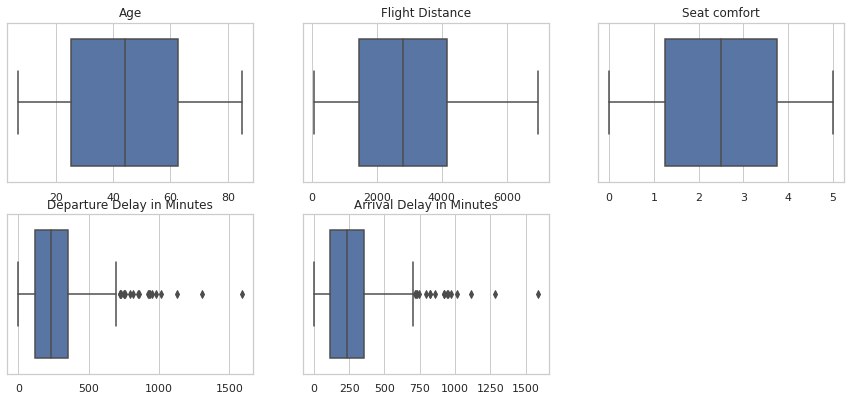

In [ ]:
# boxplot 그래프를 그려서 이상치를 확인

plt.figure(figsize=(15,10))

plt.subplot(3,3,1)
sns.boxplot(df['Age'].unique())
plt.title('Age')

plt.subplot(3,3,2)
sns.boxplot(df['Flight Distance'].unique())
plt.title('Flight Distance')

plt.subplot(3,3,3)
sns.boxplot(df['Seat comfort'].unique())
plt.title('Seat comfort')

plt.subplot(3,3,4)
sns.boxplot(df['Departure Delay in Minutes'].unique())
plt.title('Departure Delay in Minutes')

plt.subplot(3,3,5)
sns.boxplot(df['Arrival Delay in Minutes'].unique())
plt.title('Arrival Delay in Minutes')

In [ ]:
# 이상치를 제거하는 함수 remove_outlier 생성

def remove_outlier(df, col): 

  q1, q3 = np.quantile(df[col], 0.25), np.quantile(df[col], 0.75)             
  iqr = q3 - q1       
  lower, upper = q1 - (iqr * 1.5), q3 + (iqr * 1.5)   
  
  removed = df[df[col].between(lower, upper)]

  return removed

In [ ]:
df = remove_outlier(df, 'Departure Delay in Minutes')
df = remove_outlier(df, 'Arrival Delay in Minutes')
df.shape

(96111, 23)

### **c) EDA & Feature Engineering**



> **'Gender' 컬럼**



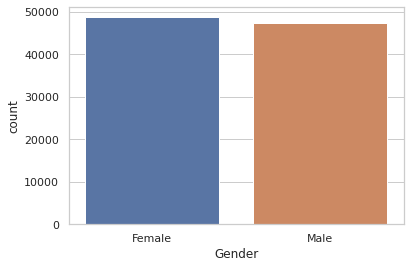

In [ ]:
# 우선 남녀 성별 비율에 대해서 확인해보겠습니다

sns.countplot(df['Gender']);

             satisfaction          
satisfaction dissatisfied satisfied
Gender                             
Female              15655     33072
Male                25260     22124


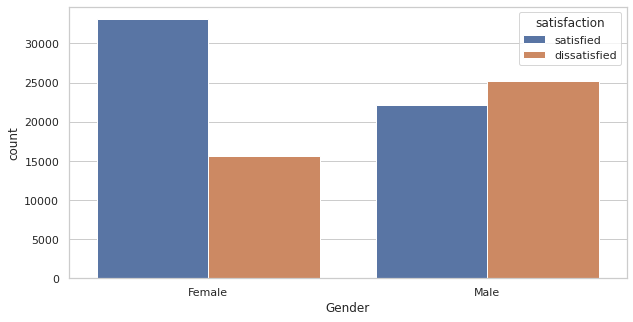

In [ ]:
# 성별에 따른 만족도를 비교해보겠습니다

df_gender = df.groupby(['Gender', 'satisfaction']).agg({'satisfaction': 'count'}).unstack()
print(df_gender)

plt.figure(figsize=(10,5))
sns.countplot(df['Gender'], hue=df['satisfaction'])
plt.show()

그래프를 그려 확인해보니, 남자보다 여자의 만족도 비율이 더 높은 것을 확인 할 수 있다. 남자는 불만족의 비율이 조금 더 높았던 반면, 여자는 두배 이상이 항공사 이용에 만족한다고 답변했다.



> **'Customer Type' 컬럼**



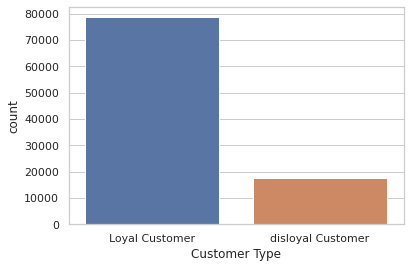

In [ ]:
# Customer Type의 분포를 확인해보겠습니다

sns.countplot(df['Customer Type']);

                  satisfaction          
satisfaction      dissatisfied satisfied
Customer Type                           
Loyal Customer           27964     50694
disloyal Customer        12951      4502


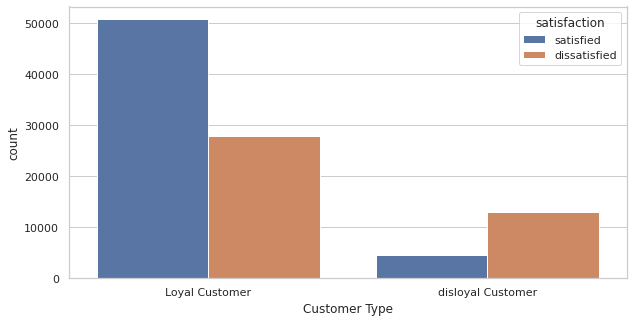

In [ ]:
# Customer Type에 따른 만족도를 비교해보겠습니다

df_cx = df.groupby(['Customer Type', 'satisfaction']).agg({'satisfaction': 'count'}).unstack()
print(df_cx)

plt.figure(figsize=(10,5))
sns.countplot(df['Customer Type'], hue=df['satisfaction'])
plt.show()

설문조사에 응한 사람들 중엔 Loyal Customer가 상대적으로 더 많은 비중을 차지 하고 있었다. disloyal Customer는 항공사 이용에 불만족했다고 대답한 사람이 더 많은 것에 비해서, Loyal Customer는 만족한다고 응답한 비율이 훨씬 더 큰 것을 확인 할 수 있다. 

> **'Age' 컬럼**




'Age'의 최소값은 7
'Age'의 최대값은 85
'Age'의 평균은 39.518119674126794
'Age'의 중간값은 40.0


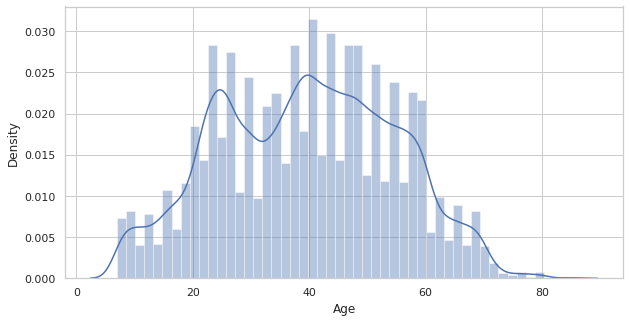

In [ ]:
print("'Age'의 최소값은", df['Age'].min())
print("'Age'의 최대값은", df['Age'].max())
print("'Age'의 평균은", df['Age'].mean())
print("'Age'의 중간값은", df['Age'].median())

# 연령대 분포를 더 자세히 확인해보겠습니다
plt.figure(figsize=(10,5))
sns.distplot(df['Age']);



> **'Type of Travel' 컬럼**



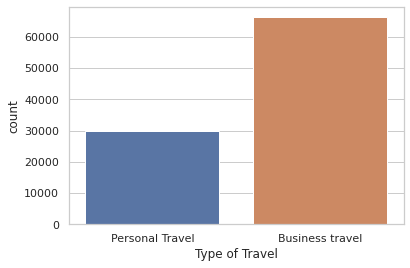

In [ ]:
# Type of Travel 에 대해서 확인해보겠습니다

sns.countplot(df['Type of Travel']);

                satisfaction          
satisfaction    dissatisfied satisfied
Type of Travel                        
Business travel        25587     40647
Personal Travel        15328     14549


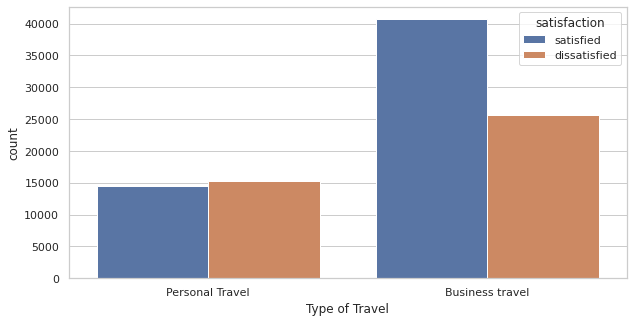

In [ ]:
# Type of Travel에 대한 만족도를 확인해보겠습니다

df_type = df.groupby(['Type of Travel', 'satisfaction']).agg({'satisfaction': 'count'}).unstack()
print(df_type)

plt.figure(figsize=(10,5))
sns.countplot(df['Type of Travel'], hue=df['satisfaction'])
plt.show()

> **'Class' 컬럼**

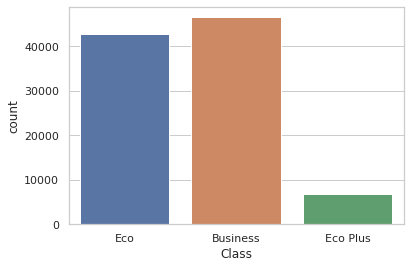

In [ ]:
sns.countplot(df['Class']);

                Type of Travel                
Type of Travel Business travel Personal Travel
Class                                         
Business                 44601            1941
Eco                      18141           24612
Eco Plus                  3492            3324


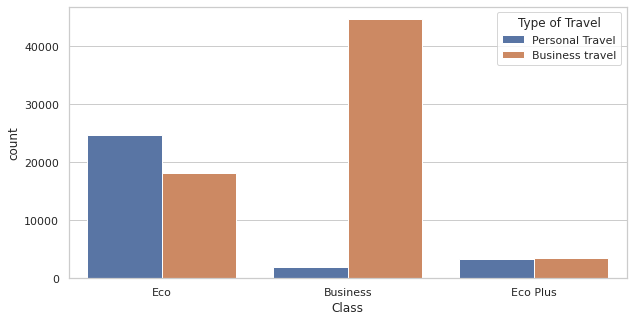

In [ ]:
df_class_type = df.groupby(['Class', 'Type of Travel']).agg({'Type of Travel': 'count'}).unstack()
print(df_class_type)

plt.figure(figsize=(10,5))
sns.countplot(df['Class'], hue=df['Type of Travel'])
plt.show()

             satisfaction          
satisfaction dissatisfied satisfied
Class                              
Business            12431     34111
Eco                 24823     17930
Eco Plus             3661      3155


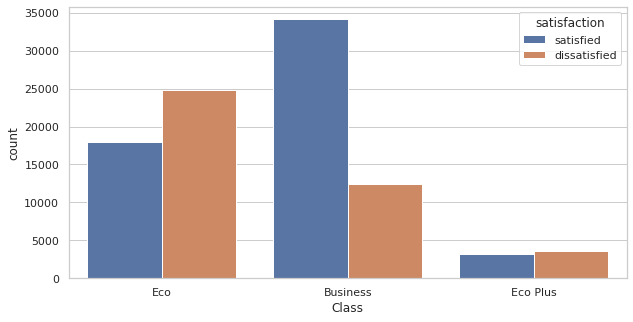

In [ ]:
df_class = df.groupby(['Class', 'satisfaction']).agg({'satisfaction': 'count'}).unstack()
print(df_class)

plt.figure(figsize=(10,5))
sns.countplot(df['Class'], hue=df['satisfaction'])
plt.show()

                    Class                
Class            Business    Eco Eco Plus
Leg room service                         
0                     116    215       30
1                    2430   4672      872
2                    6869   7987     1248
3                    7022   8011     1271
4                   16113  11468     1767
5                   13992  10400     1628


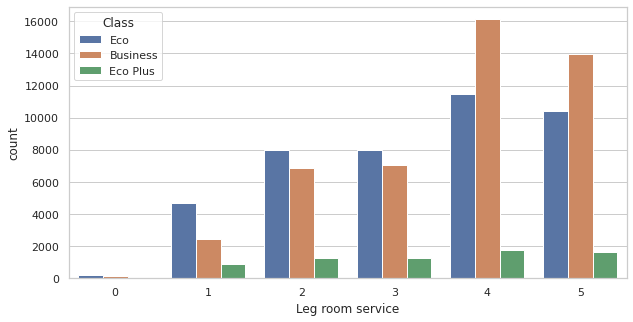

In [ ]:
df_gender = df.groupby(['Leg room service', 'Class']).agg({'Class': 'count'}).unstack()
print(df_gender)

plt.figure(figsize=(10,5))
sns.countplot(df['Leg room service'], hue=df['Class'])
plt.show()



> **'Flight Distance' 컬럼**



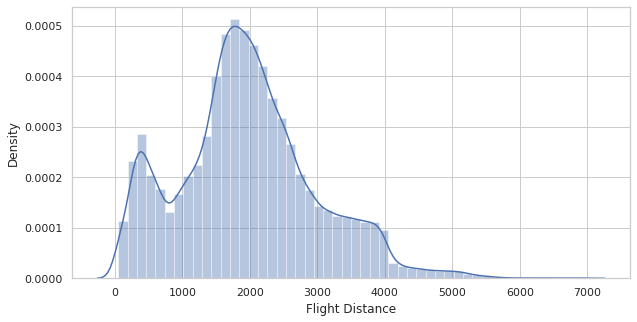

In [ ]:
# Flight Distance 분포를 확인해보겠습니다
plt.figure(figsize=(10,5))
sns.distplot(df['Flight Distance']);

In [ ]:
df.groupby('satisfaction')['Flight Distance'].mean()

satisfaction
dissatisfied   1,997.38
satisfied      1,927.19
Name: Flight Distance, dtype: float64

> **Feature Engineering**



In [ ]:
# 'Departure Delay in Minutes'와 'Arrival Delay in Minutes'를 한 컬럼으로 통합

df['Delay Time(min)'] = df['Departure Delay in Minutes'] + df['Arrival Delay in Minutes']
df.drop(['Departure Delay in Minutes','Arrival Delay in Minutes'], axis=1, inplace=True)

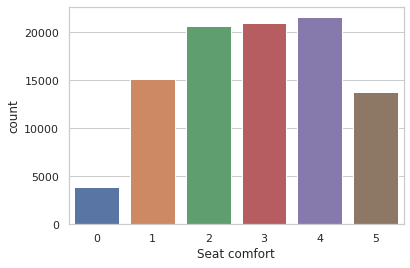

In [ ]:
sns.countplot(df['Seat comfort']);

In [ ]:
# 'Seat comfort'와 'Leg room service'를 한 컬럼으로 통합

df['Seat'] = df['Seat comfort'] + df['Leg room service']
df.drop(['Seat comfort','Leg room service'], axis=1, inplace=True)

In [ ]:
# satisfaction의 값을 0, 1로 치환

satisfaction = {'dissatisfied':0, 'satisfied':1}
df['satisfaction'] = df['satisfaction'].map(satisfaction)



> **상관관계 확인**



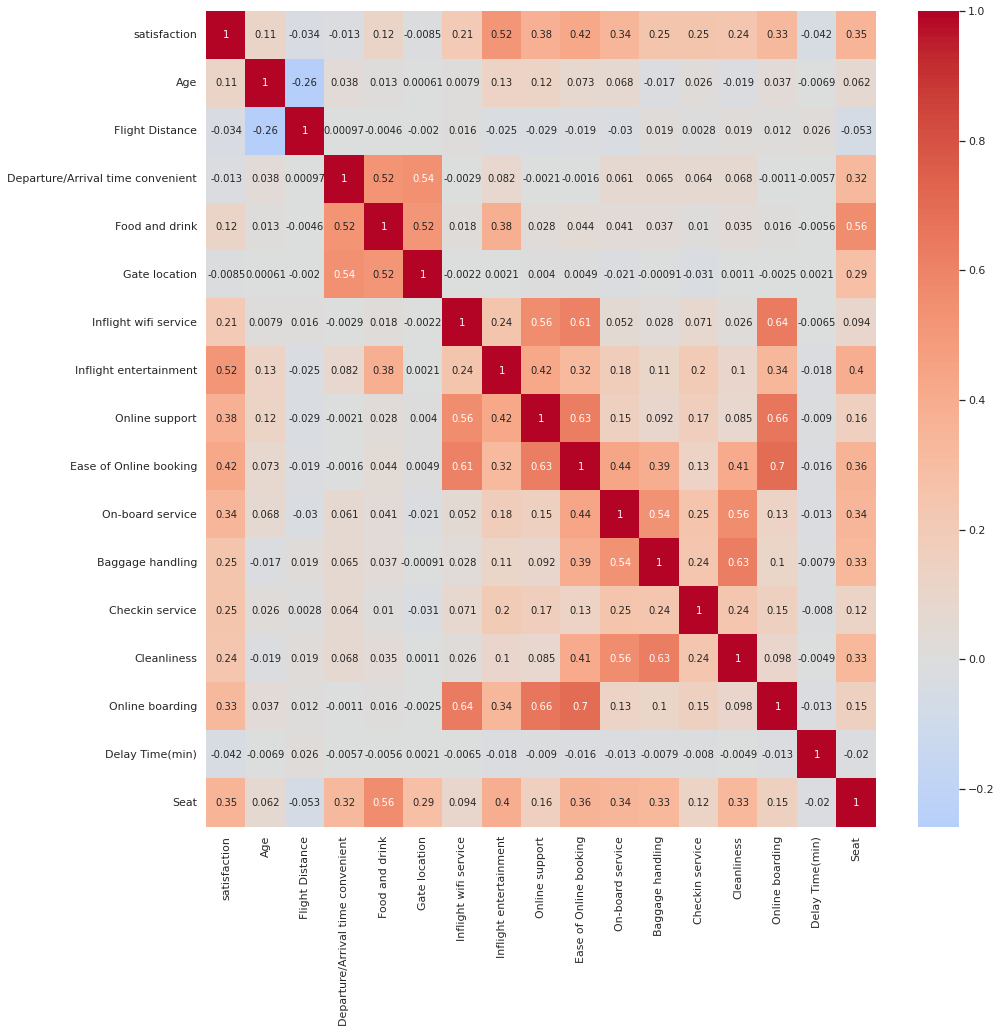

In [ ]:
# 상관관계를 히트맵으로 그려 확인해보겠습니다

corr = df.corr(method='pearson')
fig = plt.figure(figsize=(15, 15))
sns.heatmap(corr, annot=True, cmap = 'coolwarm', center = 0);

In [ ]:
# 타겟값, satisfaction과 상관관계가 낮은 컬럼들을 삭제하고 진행하겠습니다
# Flight Distance, Departure/Arrival time convenient, Gate location, Delay Time(min)

df.drop(['Flight Distance', 'Departure/Arrival time convenient', 'Gate location', 'Delay Time(min)'], axis=1, inplace=True)
df.head(3)

,satisfaction,Gender,Customer Type,Age,Type of Travel,Class,Food and drink,Inflight wifi service,Inflight entertainment,Online support,Ease of Online booking,On-board service,Baggage handling,Checkin service,Cleanliness,Online boarding,Seat
0,1,Female,Loyal Customer,65,Personal Travel,Eco,0,2,4,2,3,3,3,5,3,2,0
2,1,Female,Loyal Customer,15,Personal Travel,Eco,0,2,0,2,2,3,4,4,4,2,3
3,1,Female,Loyal Customer,60,Personal Travel,Eco,0,3,4,3,1,1,1,4,1,3,0


In [ ]:
gender = {'Female':0, 'Male':1}
df['Gender'] = df['Gender'].map(gender)

CustomerType = {'disloyal Customer':0, 'Loyal Customer':1}
df['Customer Type'] = df['Customer Type'].map(CustomerType)

TravelType = {'Personal Travel':0, 'Business travel':1}
df['Type of Travel'] = df['Type of Travel'].map(TravelType)

Class = {'Eco':0, 'Eco Plus':1, 'Business':2}
df['Class'] = df['Class'].map(Class)

In [ ]:
df.head(3)

,satisfaction,Gender,Customer Type,Age,Type of Travel,Class,Food and drink,Inflight wifi service,Inflight entertainment,Online support,Ease of Online booking,On-board service,Baggage handling,Checkin service,Cleanliness,Online boarding,Seat
0,1,0,1,65,0,0,0,2,4,2,3,3,3,5,3,2,0
2,1,0,1,15,0,0,0,2,0,2,2,3,4,4,4,2,3
3,1,0,1,60,0,0,0,3,4,3,1,1,1,4,1,3,0




---


# **3. 데이터셋 나누기 + 기준모델 설정**


##Part 1: 훈련/검증/테스트 데이터로 나누기

In [ ]:
# train, val, test 셋으로 나눠주겠습니다

train, test = train_test_split(df, train_size=0.8, test_size=0.2, random_state=2)
train, val = train_test_split(train, train_size=0.8, test_size=0.2, random_state=2)

train.shape, val.shape, test.shape

((61510, 17), (15378, 17), (19223, 17))



---


##Part 2: 타겟과 기준모델 설정

1    35371
0    26139
Name: satisfaction, dtype: int64


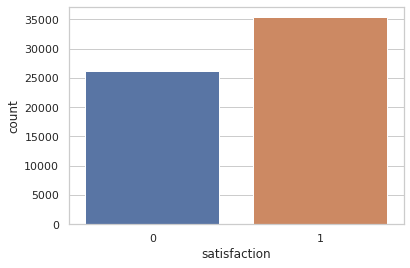

In [ ]:
# 타겟값 설정 => 'satisfaction
# 0=> dissatisfied / 1=> satisfied

target = 'satisfaction'
print(train[target].value_counts())
sns.countplot(x=train[target]);

In [ ]:
X_train = train.drop(target, axis=1)
y_train = train[target]

X_val = val.drop(target, axis=1)
y_val = val[target]

X_test = test.drop(target, axis=1)
y_test = test[target]

In [ ]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((61510, 16), (61510,), (15378, 16), (15378,), (19223, 16), (19223,))

In [ ]:
# 클래스 비율 확인

y_train = train[target]
y_train.value_counts(normalize=True)

1   0.58
0   0.42
Name: satisfaction, dtype: float64

In [ ]:
# 최다 빈도 클래스로 모든 예측을 수행해서 기준모델을 만들고, 이 기준모델로 정확도를 구해보겠습니다

major = y_train.mode()[0]
y_pred_base= [major] * len(y_train)

print('train accuracy: ', accuracy_score(y_train, y_pred_base))

train accuracy:  0.5750447081775321



---
# **4. 모델링 (Modeling)**



---
## **4-1. Random Forest Classifier**

In [ ]:
pipe_rf = make_pipeline(
    StandardScaler(),
    RandomForestClassifier(n_estimators=10,
                           n_jobs=-1,
                           max_depth=15,
                           random_state=2))

pipe_rf.fit(X_train, y_train)

print('훈련 정확도: ', pipe_rf.score(X_train, y_train))
print('검증 정확도: ', pipe_rf.score(X_val, y_val))

훈련 정확도:  0.9657779222890587
검증 정확도:  0.9302249967486019


In [ ]:
param_dist = {
    'randomforestclassifier__n_estimators': randint(1,100),
    'randomforestclassifier__max_depth': [5, 10, 15, 20, None],
    'randomforestclassifier__max_features': uniform(0, 1),
    'randomforestclassifier__min_samples_split': [1, 3, 5, 10],
    'randomforestclassifier__min_samples_leaf': [None, 5, 10, 20, 30] 
}

# fitting 3 folds for each of 30, totalling 90 fits
clf = RandomizedSearchCV(
    pipe_rf, 
    param_distributions=param_dist, 
    n_iter=30, 
    cv=3, 
    scoring='f1',  
    verbose=1,
    n_jobs=-1
)

clf.fit(X_train, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  2.5min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('standardscaler',
                                              StandardScaler(copy=True,
                                                             with_mean=True,
                                                             with_std=True)),
                                             ('randomforestclassifier',
                                              RandomForestClassifier(bootstrap=True,
                                                                     ccp_alpha=0.0,
                                                                     class_weight=None,
                                                                     criterion='gini',
                                                                     max_depth=15,
                                                                     max_features='auto',
                           

In [ ]:
print('최적 하이퍼파라미터: ', clf.best_params_)
print('MAE: ', -clf.best_score_)

최적 하이퍼파라미터:  {'randomforestclassifier__max_depth': None, 'randomforestclassifier__max_features': 0.7724181250323043, 'randomforestclassifier__min_samples_leaf': 5, 'randomforestclassifier__min_samples_split': 5, 'randomforestclassifier__n_estimators': 66}
MAE:  -0.9433174326177632


In [ ]:
pd.DataFrame(clf.cv_results_).sort_values(by='rank_test_score').T

,17,22,3,5,2,4,7,0,28,13,12,6,25,24,23,8,20,15,1,27,26,14,19,18,16,11,10,9,21,29
mean_fit_time,6.86,3.60,7.85,7.04,7.77,9.06,10.01,9.54,5.19,4.10,1.92,2.20,2.27,1.33,2.16,2.92,1.78,2.28,0.86,0.16,0.21,0.15,0.23,0.23,0.17,0.19,0.20,0.20,0.25,0.18
std_fit_time,0.58,0.08,0.11,0.12,0.11,0.16,0.35,0.47,1.41,0.11,0.04,0.08,0.09,0.08,0.16,0.37,0.23,0.12,0.06,0.01,0.00,0.02,0.01,0.02,0.02,0.01,0.03,0.01,0.01,0.03
mean_score_time,0.38,0.25,0.49,0.38,0.46,0.38,0.46,0.38,0.33,0.46,0.16,0.35,0.23,0.33,0.23,0.20,0.21,0.25,0.25,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
std_score_time,0.10,0.01,0.05,0.05,0.01,0.05,0.00,0.05,0.09,0.00,0.06,0.01,0.01,0.01,0.00,0.06,0.05,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
param_randomforestclassifier__max_depth,None,20,None,15,20,10,20,20,None,15,20,20,10,10,5,5,5,5,5,10,10,None,15,20,None,None,None,5,15,10
param_randomforestclassifier__max_features,0.77,0.70,0.71,0.82,0.56,0.97,0.89,0.97,0.47,0.29,0.48,0.21,0.33,0.09,0.36,0.57,0.62,0.60,0.12,0.90,0.75,0.81,0.61,0.83,0.49,0.34,0.01,0.06,0.25,0.18
param_randomforestclassifier__min_samples_leaf,5,5,5,5,10,10,20,30,30,20,30,20,20,20,10,10,5,5,10,20,None,20,20,30,None,10,None,5,5,30
param_randomforestclassifier__min_samples_split,5,10,3,5,5,10,5,5,5,3,5,10,3,10,3,10,3,10,5,1,5,1,1,1,3,1,1,1,1,1
param_randomforestclassifier__n_estimators,66,36,75,62,91,86,85,82,98,99,29,60,55,69,75,70,42,58,47,41,24,13,47,47,28,83,82,16,87,34
params,"{'randomforestclassifier__max_depth': None, 'r...","{'randomforestclassifier__max_depth': 20, 'ran...","{'randomforestclassifier__max_depth': None, 'r...","{'randomforestclassifier__max_depth': 15, 'ran...","{'randomforestclassifier__max_depth': 20, 'ran...","{'randomforestclassifier__max_depth': 10, 'ran...","{'randomforestclassifier__max_depth': 20, 'ran...","{'randomforestclassifier__max_depth': 20, 'ran...","{'randomforestclassifier__max_depth': None, 'r...","{'randomforestclassifier__max_depth': 15, 'ran...","{'randomforestclassifier__max_depth': 20, 'ran...","{'randomforestclassifier__max_depth': 20, 'ran...","{'randomforestclassifier__max_depth': 10, 'ran...","{'randomforestclassifier__max_depth': 10, 'ran...","{'randomforestclassifier__max_depth': 5, 'rand...","{'randomforestclassifier__max_depth': 5, 'rand...","{'randomforestclassifier__max_depth': 5, 'rand...","{'randomforestclassifier__max_depth': 5, 'rand...","{'randomforestclassifier__max_depth': 5, 'rand...","{'randomforestclassifier__max_depth': 10, 'ran...","{'randomforestclassifier__max_depth': 10, 'ran...","{'randomforestclassifier__max_depth': None, 'r...","{'randomforestclassifier__max_depth': 15, 'ran...","{'randomforestclassifier__max_depth': 20, 'ran...","{'randomforestclassifier__max_depth': None, 'r...","{'randomforestclassifier__max_depth': None, 'r...","{'randomforestclassifier__max_depth': None, 'r...","{'randomforestclassifier__max_depth': 5, 'rand...","{'randomforestclassifier__max_depth': 15, 'ran...","{'randomforestclassifier__max_depth': 10, 'ran..."


In [ ]:
# 만들어진 모델에서 가장 성능이 좋은 모델을 불러오겠습니다
pipe_rf_best = clf.best_estimator_

In [ ]:
y_pred_val = pipe_rf_best.predict(X_val)
mae = mean_absolute_error(y_val, y_pred_val)
print(mae)

0.0641175705553388


In [ ]:
y_pred_train = pipe_rf_best.predict(X_train)
y_pred_val= pipe_rf_best.predict(X_val)

print('훈련 정확도: ', pipe_rf_best.score(X_train, y_train))
print('검증 정확도: ', pipe_rf_best.score(X_val, y_val))
print('훈련 f1_score: ', f1_score(y_train, y_pred_train))
print('검증 f1_score: ', f1_score(y_val, y_pred_val))

print(classification_report(y_val, y_pred_val))

훈련 정확도:  0.9642822305316209
검증 정확도:  0.9358824294446612
훈련 f1_score:  0.9688178605390522
검증 f1_score:  0.9443692168810651
              precision    recall  f1-score   support

           0       0.92      0.93      0.92      6481
           1       0.95      0.94      0.94      8897

    accuracy                           0.94     15378
   macro avg       0.93      0.93      0.93     15378
weighted avg       0.94      0.94      0.94     15378



In [ ]:
y_test_pred = pipe_rf_best.predict(X_test)
print('테스트 정확도: ', accuracy_score(y_test, y_test_pred))

print(classification_report(y_test_pred, y_test))

테스트 정확도:  0.9326327836445925
              precision    recall  f1-score   support

           0       0.93      0.92      0.92      8368
           1       0.94      0.94      0.94     10855

    accuracy                           0.93     19223
   macro avg       0.93      0.93      0.93     19223
weighted avg       0.93      0.93      0.93     19223



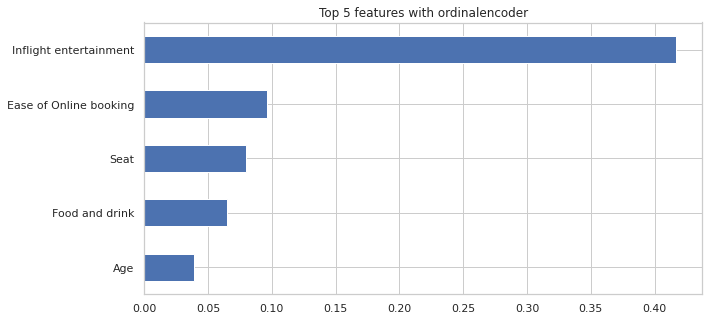

In [ ]:
# 모델의 특성 중요도를 살펴보겠습니다
rf = pipe_rf_best.named_steps['randomforestclassifier']
importances_rf = pd.Series(rf.feature_importances_, X_train.columns)

plt.figure(figsize=(10,5))
plt.title('Top 5 features with ordinalencoder')
importances_rf.sort_values()[-5:].plot.barh();

[[6023  458]
 [ 528 8369]]


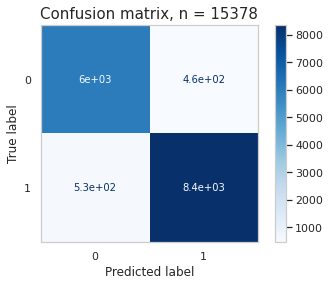

In [ ]:
from sklearn.metrics import plot_confusion_matrix
fig, ax = plt.subplots()
pcm = plot_confusion_matrix(pipe_rf_best, X_val, y_val,
                            cmap=plt.cm.Blues,
                            ax=ax);

cm=pcm.confusion_matrix
print(cm)

ax.grid(False)
plt.title(f'Confusion matrix, n = {len(y_val)}', fontsize=15)
plt.show()



---
## **4-2. XGBoost Classifier**

In [ ]:
pipe_xgb = make_pipeline(
    StandardScaler(),
    XGBClassifier(n_estimators=1000,
                  verbosity=0,
                  n_jobs=-1,
                  max_depth=7,
                  random_state=2)
)

pipe_xgb.fit(X_train, y_train);

In [ ]:
y_pred = pipe_xgb.predict(X_val)
print('검증 정확도: ', accuracy_score(y_val, y_pred))

print(classification_report(y_pred, y_val))

검증 정확도:  0.9386136038496553
              precision    recall  f1-score   support

           0       0.93      0.92      0.93      6559
           1       0.94      0.95      0.95      8819

    accuracy                           0.94     15378
   macro avg       0.94      0.94      0.94     15378
weighted avg       0.94      0.94      0.94     15378



In [ ]:
y_test_pred = pipe_xgb.predict(X_test)
print('테스트 정확도: ', accuracy_score(y_test, y_test_pred))

print(classification_report(y_test_pred, y_test))

테스트 정확도:  0.9378869063101493
              precision    recall  f1-score   support

           0       0.93      0.93      0.93      8353
           1       0.94      0.95      0.95     10870

    accuracy                           0.94     19223
   macro avg       0.94      0.94      0.94     19223
weighted avg       0.94      0.94      0.94     19223

